from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# what space are the streamline are in?
#also try AFQ whole sl set

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
# Just choose the first one
atlas_img = nib.load('/home/ariel/data/volume/Acoustic_Radiation_L.nii.gz')

In [6]:
atlas_affine = atlas_img.affine
atlas_shape = atlas_img.shape

In [7]:
atlas_shape

(157, 189, 136)

In [8]:
group_dirs = glob('/home/ariel/data/tracks/*')

In [9]:
exclude = [op.join('/home/ariel/data/tracks/', g) for g in ["cerebellum", "brainstem", "cranial nerve"]]

In [12]:
#group_dirs = [g for g in group_dirs if g not in exclude]

In [13]:
track_files_groups = [glob(op.join(d, '*.trk.gz')) for d in group_dirs]

In [14]:
track_files_groups

[['/home/ariel/data/tracks/cerebellum/MCP.trk.gz',
  '/home/ariel/data/tracks/cerebellum/ICP_R.trk.gz',
  '/home/ariel/data/tracks/cerebellum/V.trk.gz',
  '/home/ariel/data/tracks/cerebellum/SCP.trk.gz',
  '/home/ariel/data/tracks/cerebellum/CB_L.trk.gz',
  '/home/ariel/data/tracks/cerebellum/ICP_L.trk.gz',
  '/home/ariel/data/tracks/cerebellum/CB_R.trk.gz'],
 ['/home/ariel/data/tracks/brainstem/DLF_L.trk.gz',
  '/home/ariel/data/tracks/brainstem/STT_R.trk.gz',
  '/home/ariel/data/tracks/brainstem/LL_R.trk.gz',
  '/home/ariel/data/tracks/brainstem/ML_R.trk.gz',
  '/home/ariel/data/tracks/brainstem/MLF_L.trk.gz',
  '/home/ariel/data/tracks/brainstem/LL_L.trk.gz',
  '/home/ariel/data/tracks/brainstem/ML_L.trk.gz',
  '/home/ariel/data/tracks/brainstem/CTT_L.trk.gz',
  '/home/ariel/data/tracks/brainstem/STT_L.trk.gz',
  '/home/ariel/data/tracks/brainstem/MLF_R.trk.gz',
  '/home/ariel/data/tracks/brainstem/CTT_R.trk.gz',
  '/home/ariel/data/tracks/brainstem/DLF_R.trk.gz',
  '/home/ariel/dat

In [15]:
track_files = []
_ = [track_files.extend(t) for t in track_files_groups]

In [17]:
len(track_files)

78

In [13]:
n_streamlines = []
bundle_names = []
for fname in track_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [14]:
np.max(n_streamlines), np.min(n_streamlines), len(n_streamlines)

(45747, 72, 45)

In [15]:
take_n_bundles = len(n_streamlines)

In [16]:
take_n_sl = np.min(n_streamlines)

In [17]:
take_n_bundles = 45
take_n_sl = 70

In [18]:
if op.exists('./yeh-atlas-projections.npz'):
    # Read it from file:
    loaded_from_file = np.load('./yeh-atlas-projections.npz')
    labels_test = loaded_from_file['labels_test']
    labels_train = loaded_from_file['labels_train']
    data_test = loaded_from_file['data_test']
    data_train = loaded_from_file['data_train']
    data_valid = loaded_from_file['data_valid']
    labels_valid = loaded_from_file['labels_valid']
else:
    data_train, data_valid, data_test, labels_train, labels_valid, labels_test =\
        bn.partition_data(track_files, (157, 189, 136), take_n_bundles, take_n_sl)
    
    np.savez('./yeh-atlas-projections', 
             data_train=data_train, 
             data_valid=data_valid,
             data_test=data_test, 
             labels_train=labels_train, 
             labels_valid=labels_valid,
             labels_test=labels_test)

In [19]:
img_rows = 100
img_cols = 100
batch_size = 4
epochs = 24
num_classes = take_n_bundles
input_shape = (img_rows, img_cols, 1)

In [20]:
labels_train = keras.utils.to_categorical(labels_train-1, num_classes)
labels_valid = keras.utils.to_categorical(labels_valid-1, num_classes)
labels_test  = keras.utils.to_categorical(labels_test-1, num_classes)

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [23]:
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_valid, labels_valid))

Train on 1890 samples, validate on 630 samples
Epoch 1/24
1890/1890 [==============================] - 16s - loss: 0.8788 - acc: 0.7698 - val_loss: 0.2371 - val_acc: 0.9222
Epoch 2/24
1890/1890 [==============================] - 14s - loss: 0.1948 - acc: 0.9439 - val_loss: 0.1777 - val_acc: 0.9429
Epoch 3/24
1890/1890 [==============================] - 14s - loss: 0.1123 - acc: 0.9741 - val_loss: 0.2049 - val_acc: 0.9413
Epoch 4/24
1890/1890 [==============================] - 14s - loss: 0.0900 - acc: 0.9720 - val_loss: 0.1661 - val_acc: 0.9603
Epoch 5/24
1890/1890 [==============================] - 14s - loss: 0.0880 - acc: 0.9772 - val_loss: 0.0999 - val_acc: 0.9762
Epoch 6/24
1890/1890 [==============================] - 14s - loss: 0.0479 - acc: 0.9852 - val_loss: 0.1558 - val_acc: 0.9619
Epoch 7/24
1890/1890 [==============================] - 14s - loss: 0.0733 - acc: 0.9820 - val_loss: 0.2024 - val_acc: 0.9587
Epoch 8/24
1890/1890 [==============================] - 14s - loss: 0.0

In [1]:
score = model.evaluate(data_test, labels_test, verbose=0)

NameError: name 'model' is not defined

In [25]:
print(score)

[0.14242299268282063, 0.97619047619047616]


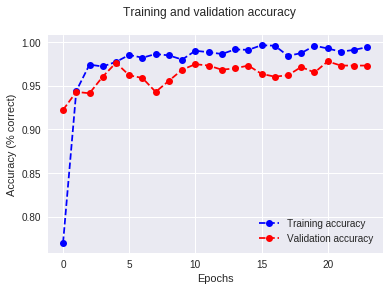

In [26]:
fig = bn.plot_accuracy(training)

In [27]:
p = model.predict(data_test, batch_size=5)

In [28]:
p_idx = np.argmax(p, axis=-1)

In [29]:
p_bundles = np.array([bundle_names[ii] for ii in p_idx])

In [30]:
loaded_from_file = np.load('./yeh-atlas-projections.npz')
labels_test = loaded_from_file['labels_test']

In [31]:
actual_labels = np.array([bundle_names[ii] for ii in (labels_test - 1).astype(int)])

In [32]:
np.mean(p_bundles == actual_labels)

0.97619047619047616

In [33]:
confusion = np.zeros((len(bundle_names), len(bundle_names)))
arr_bundle_names = np.array(bundle_names)
for xx in range(len(p_bundles)):
    idx1 = np.where(arr_bundle_names == p_bundles[xx])
    idx2 = np.where(arr_bundle_names == actual_labels[xx])
    n = np.sum(actual_labels == actual_labels[xx])
    confusion[idx1, idx2] += 1 / n

In [34]:
#sort_idx = np.argsort(arr_bundle_names)

/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


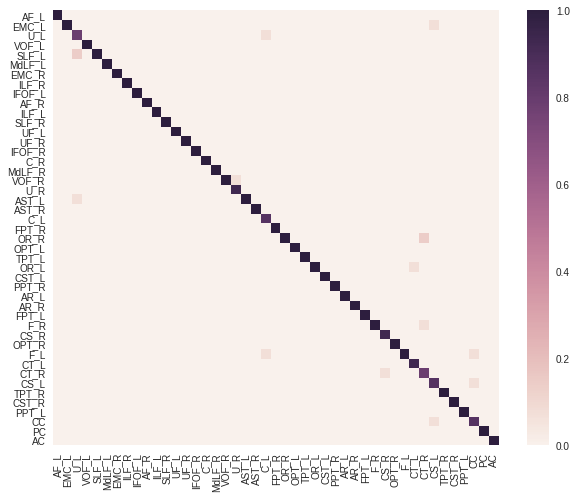

In [40]:
fig, ax = plt.subplots(1)

sns.heatmap(confusion,
            xticklabels=arr_bundle_names, 
            yticklabels=arr_bundle_names, ax=ax)
fig.set_size_inches([10, 8])

In [36]:
p_error = p[~(p_bundles == actual_labels)]
p_correct = p[p_bundles == actual_labels]

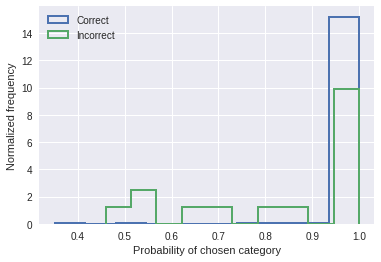

In [37]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")

In [38]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(p_bundles, actual_labels)
print(kappa)

0.975649350649
